## Project Introduction

Suppose a company runs ads through multiple channels, each with potentially different audience characteristics (e.g., Youku vs. Toutiao). This case study aims to categorize advertising channels based on their 90-day performance metrics to enable targeted measurement and optimization.

We'll analyze channels using features including: daily UV, average registration rate, average search rate, visit depth, average dwell time, order conversion rate, ad duration, creative type, ad format, cooperation model, ad dimensions, and selling points. The goal is to identify key characteristics of each channel type to support business decisions.

### Data Dimension Overview

- 889 rows, 12 dimensions (excluding channel ID). Contains missing values and outliers.

### Introduction of 13 Data Dimensions

- Variable descriptions:
  1. Channel Code – unique identifier
  2. Daily UV – unique visitors per day
  3. Avg. Registration Rate = avg. daily registrations / avg. daily visits
  4. Avg. Search Volume – average searches per visit
  5. Visit Depth = total page views / avg. daily visits
  6. Avg. Duration = total duration / avg. daily visits
  7. Order Conversion Rate = total orders / avg. daily visitors
  8. Ad Duration – days the ad was live
  9. Material Type – e.g., jpg, swf, gif, sp
  10. Ad Type – e.g., banner, tips, unknown, horizontal, pause
  11. Cooperation Model – e.g., roi, cpc, cpm, cpd
  12. Ad Size – e.g., 140x40, 308x388, etc.
  13. Selling Points – e.g., discount, full reduction, gift with purchase, flash sale, price drop, cashback

## Import Libraries and Load Data

In [67]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score  # Import silhouette coefficient metric
from sklearn.cluster import KMeans  # KMeans module
%matplotlib inline
## Set properties to prevent Chinese garbled characters
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

Standard library imports. OneHotEncoder creates N new binary features for categorical variables (1 if category matches, 0 otherwise).

In [62]:
raw_data = pd.read_csv(r'C:\Users\zhizh\Documents\GitHub\data-analyst-projects\clustering-analysis-of-advertising-effectiveness\data\ad_performance.csv')
raw_data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


Channel ID is unique identifier. Metrics from Daily UV to Ad Duration are numerical (float/int), others are categorical.

### Data review

In [63]:
# Check basic status
raw_data.head(2)  # Print first 2 records

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减


In [64]:
raw_data.info()  # Print data type distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   渠道代号    889 non-null    object 
 1   日均UV    889 non-null    float64
 2   平均注册率   889 non-null    float64
 3   平均搜索量   889 non-null    float64
 4   访问深度    889 non-null    float64
 5   平均停留时间  887 non-null    float64
 6   订单转化率   889 non-null    float64
 7   投放总时间   889 non-null    int64  
 8   素材类型    889 non-null    object 
 9   广告类型    889 non-null    object 
 10  合作方式    889 non-null    object 
 11  广告尺寸    889 non-null    object 
 12  广告卖点    889 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 90.4+ KB


In [65]:
raw_data.describe().round(2).T  # Print basic descriptive statistics

,count,mean,std,min,25%,50%,75%,max
日均UV,889.0,540.85,1634.41,0.06,6.18,114.18,466.87,25294.77
平均注册率,889.0,0.00,0.00,0.00,0.00,0.00,0.00,0.04
平均搜索量,889.0,0.03,0.11,0.00,0.00,0.00,0.01,1.04
访问深度,889.0,2.17,3.80,1.00,1.39,1.79,2.22,98.98
平均停留时间,887.0,262.67,224.36,1.64,126.02,236.55,357.98,4450.83
订单转化率,889.0,0.00,0.01,0.00,0.00,0.00,0.00,0.22
投放总时间,889.0,16.05,8.51,1.00,9.00,16.00,24.00,30.00


In [7]:
# Missing value review
na_cols = raw_data.isnull().any(axis=0)  # Check which columns have missing values
na_cols

渠道代号      False
日均UV      False
平均注册率     False
平均搜索量     False
访问深度      False
平均停留时间     True
订单转化率     False
投放总时间     False
素材类型      False
广告类型      False
合作方式      False
广告尺寸      False
广告卖点      False
dtype: bool

In [8]:
raw_data.isnull().sum().sort_values(ascending=False)  # Count missing values per column

平均停留时间    2
日均UV      0
平均注册率     0
平均搜索量     0
渠道代号      0
访问深度      0
订单转化率     0
投放总时间     0
素材类型      0
广告类型      0
合作方式      0
广告尺寸      0
广告卖点      0
dtype: int64

In [9]:
# Correlation analysis
raw_data.corr(numeric_only=True).round(2).T  # Print correlation matrix

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
日均UV,1.00,-0.05,-0.07,-0.02,0.04,-0.05,-0.04
平均注册率,-0.05,1.00,0.24,0.11,0.22,0.32,-0.01
平均搜索量,-0.07,0.24,1.00,0.06,0.17,0.13,-0.03
访问深度,-0.02,0.11,0.06,1.00,0.72,0.16,0.06
平均停留时间,0.04,0.22,0.17,0.72,1.00,0.25,0.05
订单转化率,-0.05,0.32,0.13,0.16,0.25,1.00,-0.00
投放总时间,-0.04,-0.01,-0.03,0.06,0.05,-0.00,1.00


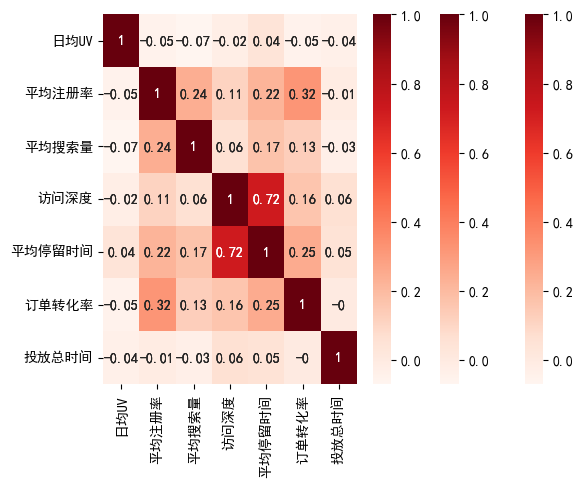

In [68]:
# Correlation visualization
import seaborn as sns 
corr = raw_data.corr(numeric_only=True).round(2)
sns.heatmap(corr,cmap='Reds',annot = True)
plt.show()

High correlation between "Visit Depth" and "Avg Dwell Time" suggests potential redundancy.

## Data Processing

Prepare data through cleaning, transformation, aggregation, and feature engineering.

In [34]:
# Remove Avg Dwell Time column
raw_data2 = raw_data.drop(['平均停留时间'],axis=1)

# Categorical variable values
cols=["素材类型","广告类型","合作方式","广告尺寸","广告卖点"]
for x in cols:
    data=raw_data2[x].unique()
    print("Variable【{0}】has values:\n{1}".format(x,data))
    print("-·"*20)

# One-hot encoding for categorical variables
cols = ['素材类型','广告类型','合作方式','广告尺寸','广告卖点'] 
model_ohe = OneHotEncoder(sparse_output=False)  # Create OneHotEncode object
ohe_matrix = model_ohe.fit_transform(raw_data2[cols])  # Direct transformation
print(ohe_matrix[:2])

Variable【素材类型】has values:
['jpg' 'swf' 'gif' 'sp']
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
Variable【广告类型】has values:
['banner' 'tips' '不确定' '横幅' '暂停']
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
Variable【合作方式】has values:
['roi' 'cpc' 'cpm' 'cpd']
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
Variable【广告尺寸】has values:
['140*40' '308*388' '450*300' '600*90' '480*360' '960*126' '900*120'
 '390*270']
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
Variable【广告卖点】has values:
['打折' '满减' '满赠' '秒杀' '直降' '满返']
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0.]]


In [35]:
# Using pandas method
ohe_matrix1=pd.get_dummies(raw_data2[cols])
ohe_matrix1.head(5)

,素材类型_gif,素材类型_jpg,素材类型_sp,素材类型_swf,广告类型_banner,广告类型_tips,广告类型_不确定,广告类型_暂停,广告类型_横幅,合作方式_cpc,...,广告尺寸_480*360,广告尺寸_600*90,广告尺寸_900*120,广告尺寸_960*126,广告卖点_打折,广告卖点_满减,广告卖点_满赠,广告卖点_满返,广告卖点_直降,广告卖点_秒杀
0,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False


In [36]:
# Data standardization
sacle_matrix = raw_data2.iloc[:, 1:7]  # Get target matrix
model_scaler = MinMaxScaler()  # Create MinMaxScaler object
data_scaled = model_scaler.fit_transform(sacle_matrix)  # MinMax normalization
print(data_scaled.round(2))

[[0.   0.18 0.02 0.01 0.12 0.66]
 [0.01 0.1  0.03 0.01 0.01 0.62]
 [0.   0.06 0.05 0.01 0.01 0.1 ]
 ...
 [0.01 0.01 0.   0.   0.   0.72]
 [0.05 0.   0.   0.   0.   0.31]
 [0.   0.   0.   0.53 0.   0.62]]


In [37]:
# Combine all dimensions
X = np.hstack((data_scaled, ohe_matrix))

## Model Building

In [49]:
# Find optimal KMeans model using silhouette score
score_list = list()  # Store average silhouette scores
silhouette_int = -1  # Initialize threshold
for n_clusters in range(2, 8):  # Test K from 2 to 7
    model_kmeans = KMeans(n_clusters=n_clusters)  # Create model
    labels_tmp = model_kmeans.fit_predict(X)  # Train model
    silhouette_tmp = silhouette_score(X, labels_tmp)  # Calculate score
    if silhouette_tmp > silhouette_int:  # If score improves
        best_k = n_clusters  # Save best K
        silhouette_int = silhouette_tmp  # Save best score
        best_kmeans = model_kmeans  # Save model
        cluster_labels_k = labels_tmp  # Save cluster labels
    score_list.append([n_clusters, silhouette_tmp])  # Append results
print('{:*^60}'.format('Silhouette Scores per K:'))
print(np.array(score_list))  # Print all scores
print('Optimal K: {0} \nSilhouette Score: {1}'.format(best_k, silhouette_int))

******************Silhouette Scores per K:******************
[[2.         0.38655493]
 [3.         0.45171035]
 [4.         0.50209812]
 [5.         0.49653989]
 [6.         0.46113524]
 [7.         0.48405989]]
Optimal K: 4 
Silhouette Score: 0.5020981194788053


C:\Users\zhizh\anaconda3\envs\anaconda-2025.04-py3.11\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\zhizh\anaconda3\envs\anaconda-2025.04-py3.11\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\zhizh\anaconda3\envs\anaconda-2025.04-py3.11\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\zhizh\anaconda3\envs\anaconda-2025.04-py

In [50]:
# Integrate raw data with cluster labels
cluster_labels = pd.DataFrame(cluster_labels_k, columns=['clusters'])  # Get labels
merge_data = pd.concat((raw_data2, cluster_labels), axis=1)  # Merge data with labels
merge_data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点,clusters
0,A203,3.69,0.0071,0.0214,2.3071,0.0258,20,jpg,banner,roi,140*40,打折,3
1,A387,178.70,0.0040,0.0324,2.0489,0.0030,19,jpg,banner,cpc,140*40,满减,3
2,A388,91.77,0.0022,0.0530,1.8771,0.0026,4,jpg,banner,cpc,140*40,满减,3
3,A389,1.09,0.0074,0.3382,4.2426,0.0153,10,jpg,banner,cpc,140*40,满减,3
4,A390,3.37,0.0028,0.1740,2.1934,0.0007,30,jpg,banner,cpc,140*40,满减,3


In [51]:
# Sample size and proportion per cluster
clustering_count = pd.DataFrame(merge_data['渠道代号'].groupby(merge_data['clusters']).count()).T.rename({'渠道代号': 'counts'})  # Count samples
clustering_ratio = (clustering_count / len(merge_data)).round(2).rename({'counts': 'percentage'})  # Calculate proportion
print(clustering_count)
print("#"*30)
print(clustering_ratio)

clusters    0    1   2    3
counts    349  313  73  154
##############################
clusters       0     1     2     3
percentage  0.39  0.35  0.08  0.17


In [53]:
# Identify key features per cluster
cluster_features = []  # Store all feature info
for line in range(best_k):  # Process each cluster
    label_data = merge_data[merge_data['clusters'] == line]  # Get cluster data

    part1_data = label_data.iloc[:, 1:7]  # Numerical features
    part1_desc = part1_data.describe().round(3)  # Descriptive stats
    merge_data1 = part1_desc.iloc[2, :]  # Get means

    part2_data = label_data.iloc[:, 7:-1]  # Categorical features
    part2_desc = part2_data.describe(include='all')  # Descriptive stats
    merge_data2 = part2_desc.iloc[2, :]  # Get modes

    merge_line = pd.concat((merge_data1, merge_data2), axis=0)  # Combine features
    cluster_features.append(merge_line)  # Append to list

In [54]:
# Output full feature info
cluster_pd = pd.DataFrame(cluster_features).T  # Convert to dataframe
print('{:*^60}'.format('Key Features per Cluster:'))
all_cluster_set = pd.concat((clustering_count, clustering_ratio, cluster_pd),axis=0)  # Combine all info
all_cluster_set

*****************Key Features per Cluster:******************


,0,1,2,3
counts,349,313,73,154
percentage,0.39,0.35,0.08,0.17
日均UV,933.015,1390.013,1904.371,2717.419
平均注册率,0.003,0.003,0.003,0.005
平均搜索量,0.064,0.152,0.106,0.051
访问深度,5.916,1.168,0.943,0.947
订单转化率,0.006,0.017,0.009,0.007
投放总时间,8.77,8.199,8.217,8.529
素材类型,jpg,swf,swf,jpg
广告类型,横幅,不确定,tips,banner


In [55]:
# Preprocess cluster data
num_sets = cluster_pd.iloc[:6, :].T.astype(np.float64)  # Get target data
num_sets_max_min = model_scaler.fit_transform(num_sets)  # Normalize
print(num_sets)
print('-'*20)
print(num_sets_max_min)

       日均UV  平均注册率  平均搜索量   访问深度  订单转化率  投放总时间
0   933.015  0.003  0.064  5.916  0.006  8.770
1  1390.013  0.003  0.152  1.168  0.017  8.199
2  1904.371  0.003  0.106  0.943  0.009  8.217
3  2717.419  0.005  0.051  0.947  0.007  8.529
--------------------
[[0.00000000e+00 0.00000000e+00 1.28712871e-01 1.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [2.56106801e-01 0.00000000e+00 1.00000000e+00 4.52443193e-02
  1.00000000e+00 0.00000000e+00]
 [5.44358789e-01 0.00000000e+00 5.44554455e-01 0.00000000e+00
  2.72727273e-01 3.15236427e-02]
 [1.00000000e+00 1.00000000e+00 0.00000000e+00 8.04343455e-04
  9.09090909e-02 5.77933450e-01]]


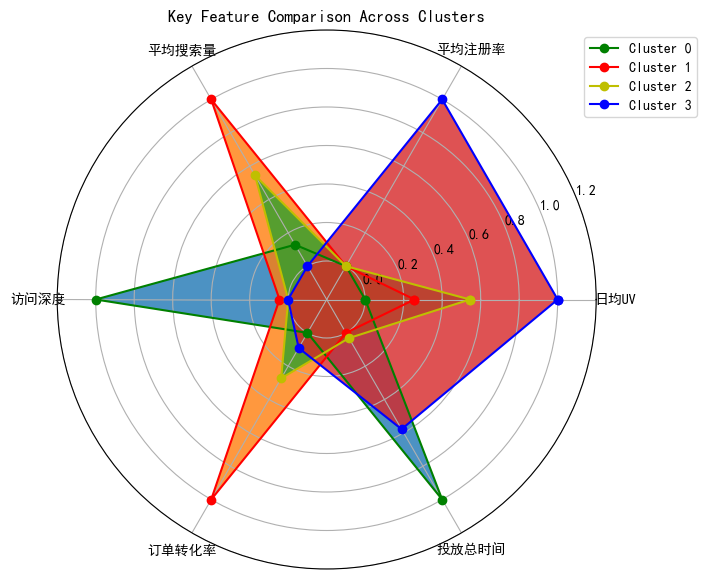

In [69]:
# Plot radar chart
fig = plt.figure(figsize=(7,7))  # Create figure
ax = fig.add_subplot(111, polar=True)  # Add polar subplot
labels = np.array(merge_data1.index)  # Data labels
cor_list = ['g', 'r', 'y', 'b']  # Cluster colors
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # Calculate angles
angles = np.concatenate((angles, [angles[0]]))  # Close polygon

# Plot each cluster
for i in range(len(num_sets)):  
    data_tmp = num_sets_max_min[i, :]  
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # Close polygon
    ax.plot(angles, data, 'o-', c=cor_list[i], label="Cluster {}".format(i))  
    ax.fill(angles, data,alpha=0.8)
    
# Format plot
ax.set_thetagrids(angles[0:-1] * 180 / np.pi, labels)  # Set polar labels
ax.set_title("Key Feature Comparison Across Clusters")  # Set title
ax.set_rlim(-0.2, 1.2)  # Set radial limits
plt.legend(loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # Position legend
plt.show()

## Conclusion

Based on the results, all channels were divided into 4 categories. The samples for each category are: 349, 313, 73, 154, corresponding to perecentages of 39%， 35%， 8% and 17%， respectively.

Category 1 (Channels indexed as Cluster 0): Apart from relatively high Visit Depth and Campaign Duration, this category of advertising media performs poorly on other attributes. Therefore, the effectiveness and quality of these advertising channels are low. Accounting for 39%, this is one of the main channel types. Business units should evaluate their actual value for advertising investment.

Category 2 (Channels indexed as Cluster 1): This category performs well on key advertising effectiveness metrics such as Average Search Volume, Daily UV, and Order Conversion Rate, except for slightly lower Visit Depth. It represents a channel type with overall good comprehensive effectiveness. However, its lower Daily UV is a weakness, meaning it cannot drive significant traffic or attract new users for the enterprise. The nature of these ads makes them suitable for user conversion, particularly for improving order-related conversions.

Category 3 (Channels indexed as Cluster 3): The defining characteristics of this advertising media category are high Daily UV and Registration Rate. Its effectiveness in "traffic acquisition" and "user acquisition" (new user sign-ups) is strong. It can be positioned within the advertising media mix as a traffic-driving channel. It aligns with the goal of "broad reach" ("广而告之") and is well-suited for "user acquisition" ("拉新") purposes.

Category 4 (Channels indexed as Cluster 4): This channel type shows no distinct strong features. Both traffic quality and traffic quantity metrics fall into a "medium" range across the board. While not outstanding, it is well-balanced. Consideration should be given to placing ads on this channel across various scenarios.